
# Loading and Preprocessing Pixels


- Add in GitHub link to how to acquire the pixel data

In [1]:
!pip install cartopy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pyproj

path = "/Users/samuelgartenstein/anaconda3/envs/my_project_env/share/proj"
pyproj.datadir.set_data_dir(path)
print("PROJ data directory has been successfully set.")


PROJ data directory has been successfully set.


/Users/samuelgartenstein/anaconda3/lib/python3.11/site-packages/pyproj/__init__.py:96: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [3]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import re
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from tqdm import tqdm

from tqdm import tqdm  # Import tqdm for progress bar
import os
import re
import numpy as np
import pandas as pd

from utils.preprocessing import subset_precip_data, pivot_precip_data, clean_and_geocode_pivot


## Define Paths and Load Latitude/Longitude Grids


In [4]:
# Define the directory where your CSV files are stored
data_dir = "data/pixel data"  # Update with your actual path

# Load latitude and longitude CSVs
latitudes = np.loadtxt(os.path.join(data_dir, "AOI_latitude.csv"), delimiter=",")
longitudes = np.loadtxt(os.path.join(data_dir, "AOI_longitude.csv"), delimiter=",")

# Ensure lat/lon match the grid shape
assert latitudes.shape == longitudes.shape, "Latitude and Longitude grids must have the same shape!"

# Get grid dimensions
lat_dim, lon_dim = latitudes.shape  # These should match the precipitation grid

print(f"Loaded latitude & longitude grids with shape: {latitudes.shape}")

Loaded latitude & longitude grids with shape: (199, 236)



## Loop Through Precipitation CSVs and Extract Data


In [5]:
# Initialize an empty dictionary to store precipitation data
precip_data = {}

# Get list of precipitation files
precip_files = sorted([f for f in os.listdir(data_dir) if "Precipitation.csv" in f])

# Loop through precipitation CSVs with tqdm progress bar
for filename in tqdm(precip_files, desc="Loading Precipitation Data", unit="file"):
    # Extract date from filename (format YYYYMMDD)
    match = re.search(r"(\d{8})", filename)
    if match:
        date_str = match.group(1)  # Extract 'YYYYMMDD'
        date = pd.to_datetime(date_str, format="%Y%m%d")  # Convert to datetime
        
        # Read CSV file
        file_path = os.path.join(data_dir, filename)
        precip_arr = np.loadtxt(file_path, delimiter=",")

        # Store in dictionary with timestamp as key
        precip_data[date] = precip_arr

print(f"Loaded {len(precip_data)} precipitation files.")

Loading Precipitation Data: 100%|████████| 3168/3168 [00:26<00:00, 118.19file/s]

Loaded 3168 precipitation files.


In [6]:
for k, v in precip_data.items():
    print(f"{k}: {np.shape(v)}")

1981-01-01 00:00:00: (199, 236)
1981-01-06 00:00:00: (199, 236)
1981-01-11 00:00:00: (199, 236)
1981-01-16 00:00:00: (199, 236)
1981-01-21 00:00:00: (199, 236)
1981-01-26 00:00:00: (199, 236)
1981-02-01 00:00:00: (199, 236)
1981-02-06 00:00:00: (199, 236)
1981-02-11 00:00:00: (199, 236)
1981-02-16 00:00:00: (199, 236)
1981-02-21 00:00:00: (199, 236)
1981-02-26 00:00:00: (199, 236)
1981-03-01 00:00:00: (199, 236)
1981-03-06 00:00:00: (199, 236)
1981-03-11 00:00:00: (199, 236)
1981-03-16 00:00:00: (199, 236)
1981-03-21 00:00:00: (199, 236)
1981-03-26 00:00:00: (199, 236)
1981-04-01 00:00:00: (199, 236)
1981-04-06 00:00:00: (199, 236)
1981-04-11 00:00:00: (199, 236)
1981-04-16 00:00:00: (199, 236)
1981-04-21 00:00:00: (199, 236)
1981-04-26 00:00:00: (199, 236)
1981-05-01 00:00:00: (199, 236)
1981-05-06 00:00:00: (199, 236)
1981-05-11 00:00:00: (199, 236)
1981-05-16 00:00:00: (199, 236)
1981-05-21 00:00:00: (199, 236)
1981-05-26 00:00:00: (199, 236)
1981-06-01 00:00:00: (199, 236)
1981-06-


## Convert Dictionary to Xarray Dataset


In [7]:
# Convert dictionary to a stacked NumPy array
precip_stack = np.stack(list(precip_data.values()))  # Shape (time, lat, lon)
time_values = list(precip_data.keys())

# Create an Xarray Dataset with `lat` and `lon` as variables, not dimensions
precip_xr = xr.Dataset(
    {
        "precipitation": (["time", "y", "x"], precip_stack),  # Use generic grid indices for dims
        "lat": (["y", "x"], latitudes),  # Store lat as a variable, not a dimension
        "lon": (["y", "x"], longitudes),  # Store lon as a variable, not a dimension
    },
    coords={"time": time_values}  # Time remains a 1D coordinate
)

# Display Dataset summary
print(precip_xr)

<xarray.Dataset>
Dimensions:        (time: 3168, y: 199, x: 236)
Coordinates:
  * time           (time) datetime64[ns] 1981-01-01 1981-01-06 ... 2024-12-26
Dimensions without coordinates: y, x
Data variables:
    precipitation  (time, y, x) float64 12.02 12.61 12.71 ... 30.79 32.16 31.27
    lat            (y, x) float64 -8.175 -8.175 -8.175 ... -18.07 -18.07 -18.07
    lon            (y, x) float64 21.97 22.02 22.07 22.12 ... 33.62 33.67 33.72


### Plot to Verifty Data

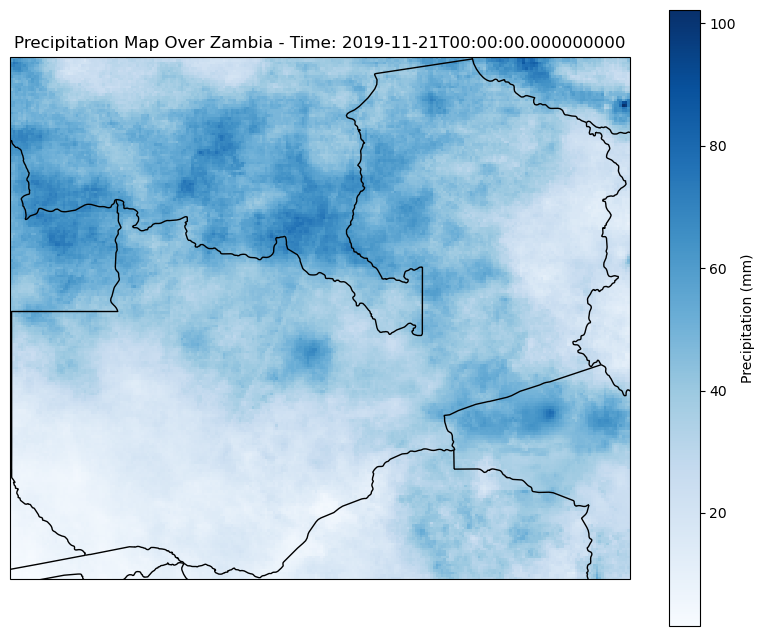

In [8]:
# Extract time slice (e.g., first time step)
time_index = 2800  # Modify this for different time steps
precip_slice = precip_xr["precipitation"].isel(time=time_index)

# Get lat/lon values from stored variables
lat_values = precip_xr["lat"].values
lon_values = precip_xr["lon"].values

# Create plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot precipitation data
pc = ax.pcolormesh(
    lon_values, lat_values, precip_slice, cmap="Blues", shading="auto"
)

# Add colorbar
cbar = plt.colorbar(pc, ax=ax, orientation="vertical", label="Precipitation (mm)")

# Add country borders (this replaces `zambia_gdf`)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=1)  # Adds country borders

# Add coastline (optional)
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.8)

# Set title
ax.set_title(f"Precipitation Map Over Zambia - Time: {precip_xr['time'].values[time_index]}")

# Show plot
plt.show()


### AOI Masking

One feature of our pixel collection is that will collect data pixels that were not in our geometry. As a result, I will use boundaries to mask those that are not in Zambia.

In [9]:
from utils.preprocessing import load_fao_gaul_data
import ee
import geemap


ee.Authenticate()
ee.Initialize(project='ee-sg4283') #Replace with your ID

zambia_gdf_0, counties_list_level0 = load_fao_gaul_data(admin_level="level0")
counties_list_level0

['Zambia']

In [10]:
zambia_gdf_0

,geometry,ADM0_CODE,ADM0_NAME,DISP_AREA,EXP0_YEAR,STATUS,STR0_YEAR,Shape_Area,Shape_Leng
0,"POLYGON ((21.99921 -16.20594, 22.00046 -16.207...",270,Zambia,NO,3000,Member State,1000,62.744281,54.196571


In [11]:
aoi_gdf = zambia_gdf_0.copy()

print(aoi_gdf)

                                            geometry  ADM0_CODE ADM0_NAME  \
0  POLYGON ((21.99921 -16.20594, 22.00046 -16.207...        270    Zambia   

  DISP_AREA  EXP0_YEAR        STATUS  STR0_YEAR  Shape_Area  Shape_Leng  
0        NO       3000  Member State       1000   62.744281   54.196571  


In [12]:
# Convert dataset lat/lon into a list of Point geometries
points = [Point(lon, lat) for lon, lat in zip(precip_xr.lon.values.flatten(), precip_xr.lat.values.flatten())]

# Create a GeoDataFrame of pixel locations
pixel_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")

# Create a boolean mask where True means the pixel is inside the AOI
valid_mask = pixel_gdf.within(aoi_gdf.unary_union).values.reshape(precip_xr.lat.shape)  # Reshape to match dataset dimensions

valid_mask

/var/folders/kb/wc8mw5490w942nfv1syxgqjc0000gn/T/ipykernel_46749/2755457095.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  valid_mask = pixel_gdf.within(aoi_gdf.unary_union).values.reshape(precip_xr.lat.shape)  # Reshape to match dataset dimensions


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [13]:
# Convert valid_mask to an xarray DataArray
valid_mask_da = xr.DataArray(
    valid_mask, 
    dims=("y", "x"),  # Ensure it matches precip_xr lat/lon dimensions
    coords={"lat": (("y", "x"), precip_xr.lat.values), "lon": (("y", "x"), precip_xr.lon.values)}
)

# Check dimensions
print(valid_mask_da)


<xarray.DataArray (y: 199, x: 236)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    lat      (y, x) float64 -8.175 -8.175 -8.175 -8.175 ... -18.07 -18.07 -18.07
    lon      (y, x) float64 21.97 22.02 22.07 22.12 ... 33.57 33.62 33.67 33.72
Dimensions without coordinates: y, x


In [14]:
# Apply the mask to filter dataset within AOI
precip_xr = precip_xr.where(valid_mask_da, drop=True)

# Print the new dataset dimensions after filtering
print(precip_xr)

<xarray.Dataset>
Dimensions:        (time: 3168, y: 197, x: 234)
Coordinates:
    lat            (y, x) float64 -8.225 -8.225 -8.225 ... -18.02 -18.02 -18.02
    lon            (y, x) float64 22.02 22.07 22.12 22.17 ... 33.57 33.62 33.67
  * time           (time) datetime64[ns] 1981-01-01 1981-01-06 ... 2024-12-26
Dimensions without coordinates: y, x
Data variables:
    precipitation  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan


## Plot

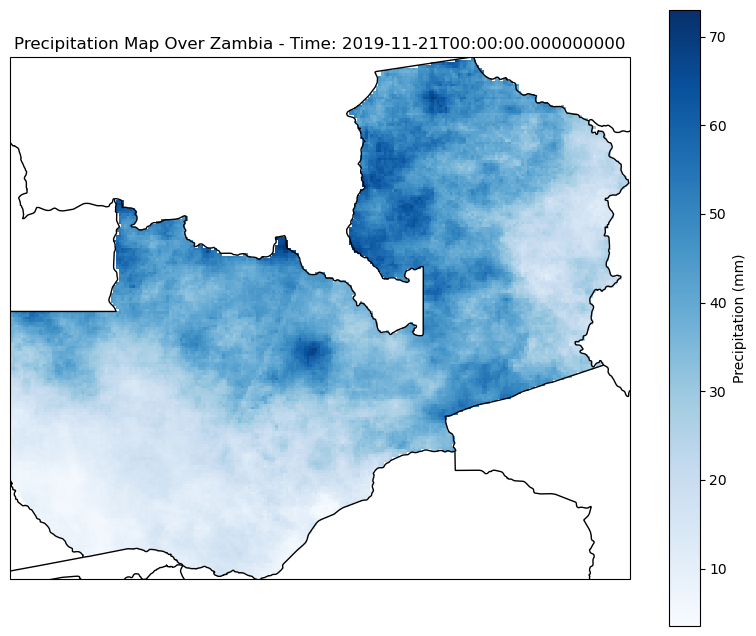

In [15]:
# Extract time slice (e.g., first time step)
time_index = 2800  # Modify this for different time steps
precip_slice = precip_xr["precipitation"].isel(time=time_index)

# Get lat/lon values from stored variables
lat_values = precip_xr["lat"].values
lon_values = precip_xr["lon"].values

# Create plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot precipitation data
pc = ax.pcolormesh(
    lon_values, lat_values, precip_slice, cmap="Blues", shading="auto"
)

# Add colorbar
cbar = plt.colorbar(pc, ax=ax, orientation="vertical", label="Precipitation (mm)")

# Add country borders (this replaces `zambia_gdf`)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=1)  # Adds country borders

# Add coastline (optional)
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.8)

# Set title
ax.set_title(f"Precipitation Map Over Zambia - Time: {precip_xr['time'].values[time_index]}")

# Show plot
plt.show()


### Subsetting Data

- Done for convience since the script takes a while to process in bulk

In [16]:
# Generate time ranges dynamically from 1981 to 2024 in 5-year steps
time_ranges = {
    f"{start % 100:02d}_{(start + 4) % 100:02d}": (f"{start}-01-01", f"{start + 4}-12-31")
    for start in range(1981, 2025, 5)  # Step by 5 years
}

# Step 1: Subset precipitation data for each time period
precip_subsets = subset_precip_data(precip_xr, time_ranges)

# Step 2: Access individual subsets dynamically
created_subsets = []  # List to store created subset names
for label in time_ranges.keys():
    var_name = f"precip_{label}"  # Example: precip_81_85
    globals()[var_name] = precip_subsets[label]
    created_subsets.append(var_name)  # Store for verification

# Print to confirm
print(f"Created subsets: {created_subsets}")

Created subsets: ['precip_81_85', 'precip_86_90', 'precip_91_95', 'precip_96_00', 'precip_01_05', 'precip_06_10', 'precip_11_15', 'precip_16_20', 'precip_21_25']


In [17]:
# Verifying Output
print(precip_21_25)


<xarray.Dataset>
Dimensions:        (time: 288, y: 197, x: 234)
Coordinates:
    lat            (y, x) float64 -8.225 -8.225 -8.225 ... -18.02 -18.02 -18.02
    lon            (y, x) float64 22.02 22.07 22.12 22.17 ... 33.57 33.62 33.67
  * time           (time) datetime64[ns] 2021-01-01 2021-01-06 ... 2024-12-26
Dimensions without coordinates: y, x
Data variables:
    precipitation  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan



### Converting to Geodataframes


In [18]:
# Get all subset labels from time_ranges
subset_labels = list(time_ranges.keys())  # All generated labels (e.g., ['81_85', '86_90', ..., '21_24'])

# Dictionaries to store pivoted and geocoded DataFrames
df_pivoted_subsets = {}
gdf_geocoded_subsets = {}

# Loop through all subsets
for label in subset_labels:
    var_name = f"precip_{label}"  # Example: precip_81_85
    df_var_name = f"df_{label}"   # Example: df_81_85
    gdf_var_name = f"gdf_{label}" # Example: gdf_81_85

    # Pivot the precipitation dataset
    df_pivoted_subsets[df_var_name] = pivot_precip_data(globals()[var_name])

    # Geocode and clean the pivoted DataFrame
    gdf_geocoded_subsets[gdf_var_name] = clean_and_geocode_pivot(df_pivoted_subsets[df_var_name])

    print(f"Processed {var_name} -> {df_var_name} -> {gdf_var_name}")

# Print all processed variable names for verification
print("Pivoted DataFrames:", list(df_pivoted_subsets.keys()))
print("Geocoded GeoDataFrames:", list(gdf_geocoded_subsets.keys()))

Pivoting Data: 100%|████████████| 46098/46098 [00:35<00:00, 1292.97grid point/s]


DataFrame shape after pivoting: (46098, 360)
DataFrame shape after dropping NaNs: (25091, 362)
GeoDataFrame shape after conversion: (25091, 364)
Processed precip_81_85 -> df_81_85 -> gdf_81_85


Pivoting Data: 100%|████████████| 46098/46098 [00:28<00:00, 1594.11grid point/s]


DataFrame shape after pivoting: (46098, 360)
DataFrame shape after dropping NaNs: (25091, 362)
GeoDataFrame shape after conversion: (25091, 364)
Processed precip_86_90 -> df_86_90 -> gdf_86_90


Pivoting Data: 100%|████████████| 46098/46098 [00:28<00:00, 1611.67grid point/s]


DataFrame shape after pivoting: (46098, 360)
DataFrame shape after dropping NaNs: (25091, 362)
GeoDataFrame shape after conversion: (25091, 364)
Processed precip_91_95 -> df_91_95 -> gdf_91_95


Pivoting Data: 100%|████████████| 46098/46098 [00:24<00:00, 1911.09grid point/s]


DataFrame shape after pivoting: (46098, 360)
DataFrame shape after dropping NaNs: (25091, 362)
GeoDataFrame shape after conversion: (25091, 364)
Processed precip_96_00 -> df_96_00 -> gdf_96_00


Pivoting Data: 100%|████████████| 46098/46098 [00:27<00:00, 1656.68grid point/s]


DataFrame shape after pivoting: (46098, 360)
DataFrame shape after dropping NaNs: (25091, 362)
GeoDataFrame shape after conversion: (25091, 364)
Processed precip_01_05 -> df_01_05 -> gdf_01_05


Pivoting Data: 100%|████████████| 46098/46098 [00:28<00:00, 1633.95grid point/s]


DataFrame shape after pivoting: (46098, 360)
DataFrame shape after dropping NaNs: (25091, 362)
GeoDataFrame shape after conversion: (25091, 364)
Processed precip_06_10 -> df_06_10 -> gdf_06_10


Pivoting Data: 100%|████████████| 46098/46098 [00:25<00:00, 1832.42grid point/s]


DataFrame shape after pivoting: (46098, 360)
DataFrame shape after dropping NaNs: (25091, 362)
GeoDataFrame shape after conversion: (25091, 364)
Processed precip_11_15 -> df_11_15 -> gdf_11_15


Pivoting Data: 100%|████████████| 46098/46098 [00:24<00:00, 1894.42grid point/s]


DataFrame shape after pivoting: (46098, 360)
DataFrame shape after dropping NaNs: (25091, 362)
GeoDataFrame shape after conversion: (25091, 364)
Processed precip_16_20 -> df_16_20 -> gdf_16_20


Pivoting Data: 100%|████████████| 46098/46098 [00:20<00:00, 2260.18grid point/s]


DataFrame shape after pivoting: (46098, 288)
DataFrame shape after dropping NaNs: (25091, 290)
GeoDataFrame shape after conversion: (25091, 292)
Processed precip_21_25 -> df_21_25 -> gdf_21_25
Pivoted DataFrames: ['df_81_85', 'df_86_90', 'df_91_95', 'df_96_00', 'df_01_05', 'df_06_10', 'df_11_15', 'df_16_20', 'df_21_25']
Geocoded GeoDataFrames: ['gdf_81_85', 'gdf_86_90', 'gdf_91_95', 'gdf_96_00', 'gdf_01_05', 'gdf_06_10', 'gdf_11_15', 'gdf_16_20', 'gdf_21_25']


In [19]:
# Loop through all subset labels and assign variables dynamically
for label in subset_labels:
    gdf_var_name = f"gdf_{label}"  # Example: gdf_81_85
    globals()[gdf_var_name] = gdf_geocoded_subsets[f"gdf_{label}"]

# Print to verify available variables
print("Available geocoded GeoDataFrames:")
print([f"gdf_{label}" for label in subset_labels])

Available geocoded GeoDataFrames:
['gdf_81_85', 'gdf_86_90', 'gdf_91_95', 'gdf_96_00', 'gdf_01_05', 'gdf_06_10', 'gdf_11_15', 'gdf_16_20', 'gdf_21_25']


## Combining All Geodataframes

In [20]:
# Ensure all GeoDataFrames use the same index (Pixel_ID, lat, lon, geometry)
gdf_list = [
    gdf_geocoded_subsets[f"gdf_{label}"].set_index(["Pixel_ID", "lat", "lon", "geometry"])
    for label in subset_labels
]

# Concatenate and ensure all dates are included
combined_gdf = pd.concat(gdf_list, axis=1, join="outer")

# Fill missing precipitation values with 0 (or use another method if preferred)
combined_gdf.fillna(0, inplace=True)

# Reset index to restore it as a standard column
combined_gdf.reset_index(inplace=True)

combined_gdf.head(10)

,Pixel_ID,lat,lon,geometry,1981-01-01 00:00:00,1981-01-06 00:00:00,1981-01-11 00:00:00,1981-01-16 00:00:00,1981-01-21 00:00:00,1981-01-26 00:00:00,...,2024-11-11 00:00:00,2024-11-16 00:00:00,2024-11-21 00:00:00,2024-11-26 00:00:00,2024-12-01 00:00:00,2024-12-06 00:00:00,2024-12-11 00:00:00,2024-12-16 00:00:00,2024-12-21 00:00:00,2024-12-26 00:00:00
0,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),3.842418,10.770559,10.102783,18.510838,38.394104,50.656479,...,6.585561,0.790254,4.554868,4.191539,1.146677,3.238929,2.243016,29.210516,11.025814,58.445751
1,Pixel 2,-18.024985,26.674978,POINT (26.67498 -18.02499),3.830561,10.702859,10.046490,18.413303,38.096268,50.378902,...,7.926045,0.807285,4.962431,4.299706,1.292190,4.051677,2.016637,25.534887,8.303064,55.767761
2,Pixel 3,-18.024985,26.724978,POINT (26.72498 -18.02499),3.829749,10.753845,10.124648,18.601490,38.391006,50.936378,...,8.241493,0.785083,4.835389,4.866858,1.377180,5.228349,2.957044,27.842638,8.789117,56.645363
3,Pixel 4,-17.974985,25.874979,POINT (25.87498 -17.97499),4.250526,7.727470,10.004998,16.987642,52.295204,58.546246,...,8.623020,5.686763,7.536818,6.417583,2.249987,3.269405,2.956911,35.710590,16.631397,70.757935
4,Pixel 5,-17.974985,25.924979,POINT (25.92498 -17.97499),4.235626,7.684377,10.075590,16.985386,52.106358,59.497044,...,8.587643,5.542754,7.463666,5.903148,2.222576,2.898495,2.906598,35.754276,18.127281,71.857887
5,Pixel 6,-17.974985,25.974979,POINT (25.97498 -17.97499),4.225826,7.638363,10.132318,16.938299,51.877792,60.266033,...,8.254246,5.407991,7.426940,5.404581,2.246878,2.988797,2.921427,36.614452,16.253300,67.787781
6,Pixel 7,-17.974985,26.024979,POINT (26.02498 -17.97499),5.233095,9.324175,11.537490,22.063030,50.763546,63.677067,...,10.298810,5.117182,7.701975,6.523453,2.134570,2.903688,3.490850,34.908218,15.881861,64.593430
7,Pixel 8,-17.974985,26.074979,POINT (26.07498 -17.97499),5.137114,9.170840,11.466964,21.818884,50.208141,63.806789,...,11.292031,4.941502,6.830719,6.984037,1.986564,2.758505,3.329603,33.056938,13.981686,61.348896
8,Pixel 9,-17.974985,26.524978,POINT (26.52498 -17.97499),5.601390,11.908092,12.296690,27.405903,42.714321,65.691711,...,6.170274,1.805921,4.296824,4.632841,1.158946,1.792258,1.776193,27.657879,8.290079,60.338211
9,Pixel 10,-17.974985,26.574978,POINT (26.57498 -17.97499),5.551239,11.749733,12.160101,27.104929,42.166019,65.113235,...,6.562373,1.715269,4.451842,4.053199,1.199300,1.870384,2.205950,28.280350,8.510204,58.326599


## Preprocessing Precipitation Data

In [21]:
precip_gdf = combined_gdf.copy()
precip_gdf.head(10)

,Pixel_ID,lat,lon,geometry,1981-01-01 00:00:00,1981-01-06 00:00:00,1981-01-11 00:00:00,1981-01-16 00:00:00,1981-01-21 00:00:00,1981-01-26 00:00:00,...,2024-11-11 00:00:00,2024-11-16 00:00:00,2024-11-21 00:00:00,2024-11-26 00:00:00,2024-12-01 00:00:00,2024-12-06 00:00:00,2024-12-11 00:00:00,2024-12-16 00:00:00,2024-12-21 00:00:00,2024-12-26 00:00:00
0,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),3.842418,10.770559,10.102783,18.510838,38.394104,50.656479,...,6.585561,0.790254,4.554868,4.191539,1.146677,3.238929,2.243016,29.210516,11.025814,58.445751
1,Pixel 2,-18.024985,26.674978,POINT (26.67498 -18.02499),3.830561,10.702859,10.046490,18.413303,38.096268,50.378902,...,7.926045,0.807285,4.962431,4.299706,1.292190,4.051677,2.016637,25.534887,8.303064,55.767761
2,Pixel 3,-18.024985,26.724978,POINT (26.72498 -18.02499),3.829749,10.753845,10.124648,18.601490,38.391006,50.936378,...,8.241493,0.785083,4.835389,4.866858,1.377180,5.228349,2.957044,27.842638,8.789117,56.645363
3,Pixel 4,-17.974985,25.874979,POINT (25.87498 -17.97499),4.250526,7.727470,10.004998,16.987642,52.295204,58.546246,...,8.623020,5.686763,7.536818,6.417583,2.249987,3.269405,2.956911,35.710590,16.631397,70.757935
4,Pixel 5,-17.974985,25.924979,POINT (25.92498 -17.97499),4.235626,7.684377,10.075590,16.985386,52.106358,59.497044,...,8.587643,5.542754,7.463666,5.903148,2.222576,2.898495,2.906598,35.754276,18.127281,71.857887
5,Pixel 6,-17.974985,25.974979,POINT (25.97498 -17.97499),4.225826,7.638363,10.132318,16.938299,51.877792,60.266033,...,8.254246,5.407991,7.426940,5.404581,2.246878,2.988797,2.921427,36.614452,16.253300,67.787781
6,Pixel 7,-17.974985,26.024979,POINT (26.02498 -17.97499),5.233095,9.324175,11.537490,22.063030,50.763546,63.677067,...,10.298810,5.117182,7.701975,6.523453,2.134570,2.903688,3.490850,34.908218,15.881861,64.593430
7,Pixel 8,-17.974985,26.074979,POINT (26.07498 -17.97499),5.137114,9.170840,11.466964,21.818884,50.208141,63.806789,...,11.292031,4.941502,6.830719,6.984037,1.986564,2.758505,3.329603,33.056938,13.981686,61.348896
8,Pixel 9,-17.974985,26.524978,POINT (26.52498 -17.97499),5.601390,11.908092,12.296690,27.405903,42.714321,65.691711,...,6.170274,1.805921,4.296824,4.632841,1.158946,1.792258,1.776193,27.657879,8.290079,60.338211
9,Pixel 10,-17.974985,26.574978,POINT (26.57498 -17.97499),5.551239,11.749733,12.160101,27.104929,42.166019,65.113235,...,6.562373,1.715269,4.451842,4.053199,1.199300,1.870384,2.205950,28.280350,8.510204,58.326599



### Convert wide-format precipitation data to long format

- Please allow for 30 to 60 seconds

In [22]:
# Identify the ID and geography columns (these should remain as identifiers)
id_vars = ['Pixel_ID', 'lat', 'lon', 'geometry']

# Identify the precipitation date columns (all columns that are dates)
value_vars = [col for col in precip_gdf.columns if col not in id_vars]

# Melt the DataFrame to long format
precip_long = precip_gdf.melt(id_vars=id_vars, 
                              value_vars=value_vars, 
                              var_name='date', 
                              value_name='precipitation')

# Convert 'date' column to datetime format
precip_long['date'] = pd.to_datetime(precip_long['date'])

# Create a new column for 'month_year' (year and month only)
precip_long['month_year'] = precip_long['date'].dt.to_period('M')

# Convert 'month_year' back to a datetime format
precip_long['month_year'] = precip_long['month_year'].dt.to_timestamp()

In [23]:
print("First Five Rows: \n", precip_long.head(), "\n")
print("Last Five Rows: \n", precip_long.tail(), "\n")
print("Shape: \n", precip_long.shape, "\n")

First Five Rows: 
   Pixel_ID        lat        lon                    geometry       date  \
0  Pixel 1 -18.024985  26.624978  POINT (26.62498 -18.02499) 1981-01-01   
1  Pixel 2 -18.024985  26.674978  POINT (26.67498 -18.02499) 1981-01-01   
2  Pixel 3 -18.024985  26.724978  POINT (26.72498 -18.02499) 1981-01-01   
3  Pixel 4 -17.974985  25.874979  POINT (25.87498 -17.97499) 1981-01-01   
4  Pixel 5 -17.974985  25.924979  POINT (25.92498 -17.97499) 1981-01-01   

   precipitation month_year  
0       3.842418 1981-01-01  
1       3.830561 1981-01-01  
2       3.829749 1981-01-01  
3       4.250526 1981-01-01  
4       4.235626 1981-01-01   

Last Five Rows: 
              Pixel_ID       lat        lon                   geometry  \
79488283  Pixel 25087 -8.274993  30.624975  POINT (30.62498 -8.27499)   
79488284  Pixel 25088 -8.274993  30.674975  POINT (30.67497 -8.27499)   
79488285  Pixel 25089 -8.274993  30.724975  POINT (30.72497 -8.27499)   
79488286  Pixel 25090 -8.274993  30.77


### Aggregate Monthly Precipitation for Each Pixel

- Please allow for 60 seconds

In [24]:
# Aggregate precipitation by summing the values for each month
precip_monthly = precip_long.groupby(
    ['Pixel_ID', 'lat', 'lon', 'geometry', 'month_year']
)['precipitation'].sum().reset_index()

precip_monthly['month_year'] = precip_monthly['month_year'].dt.strftime('%Y-%m')

precip_monthly.head(10)

,Pixel_ID,lat,lon,geometry,month_year,precipitation
0,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),1981-01,132.277181
1,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),1981-02,275.500200
2,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),1981-03,95.874663
3,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),1981-04,10.009501
4,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),1981-05,0.944366
5,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),1981-06,0.492608
6,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),1981-07,0.027317
7,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),1981-08,0.007319
8,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),1981-09,0.647343
9,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),1981-10,6.727263


In [26]:
precip_monthly.shape

(13248048, 6)

### Transform Precipitation Data to Wide Format with Month-Year Columns


In [27]:
# Pivot the DataFrame to have month_year as columns with precipitation as values
precip_monthly_pivot = precip_monthly.pivot(
    index=['Pixel_ID', 'lat', 'lon', 'geometry'], 
    columns='month_year', 
    values='precipitation'
).reset_index()

# Rename columns to ensure they are properly formatted
precip_monthly_pivot.columns.name = None  # Remove the multi-index column name

# Restore GeoDataFrame properties
precip_monthly_pivot = gpd.GeoDataFrame(precip_monthly_pivot, geometry='geometry', crs="EPSG:4326")

# Display the transformed DataFrame
precip_monthly_pivot.head()

,Pixel_ID,lat,lon,geometry,1981-01,1981-02,1981-03,1981-04,1981-05,1981-06,...,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
0,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),132.277181,275.500200,95.874663,10.009501,0.944366,0.492608,...,19.134578,14.406753,0.726252,0.636127,0.031795,0.007666,0.575926,4.784238,26.953614,105.310704
1,Pixel 10,-17.974985,26.574978,POINT (26.57498 -17.97499),163.845256,288.870520,100.699162,10.258410,0.993865,0.560482,...,18.174232,14.894662,0.760818,0.714424,0.033372,0.026550,0.676291,4.457126,28.609095,100.392787
2,Pixel 100,-17.824985,27.124978,POINT (27.12498 -17.82499),160.450290,327.135210,86.631998,23.953244,1.388148,0.882137,...,24.130263,35.210871,1.788146,1.152400,0.051194,0.182760,0.960939,9.027471,34.134363,108.992560
3,Pixel 1000,-17.174986,26.074979,POINT (26.07498 -17.17499),201.698848,250.168682,74.020919,11.546471,1.797810,0.843880,...,39.127420,18.902663,1.610932,1.045238,0.053220,0.120569,1.462278,9.447424,42.048154,105.270535
4,Pixel 10000,-14.224988,30.824975,POINT (30.82497 -14.22499),168.201036,275.608287,130.160823,38.810421,2.988148,0.471426,...,38.818757,23.222824,3.179461,0.623085,1.606937,0.574517,0.839672,17.195097,79.533707,115.426741


In [28]:
precip_monthly_pivot.shape

(25091, 532)

### Convert Pixel_ID to numeric for accurate sorting and reorder rows accordingly

In [29]:
# Convert Pixel_ID to numeric for proper sorting
precip_monthly_pivot['Pixel_ID_numeric'] = precip_monthly_pivot['Pixel_ID'].str.extract('(\d+)').astype(int)

# Sort by the numeric Pixel_ID
precip_monthly_pivot = precip_monthly_pivot.sort_values(by='Pixel_ID_numeric').drop(columns=['Pixel_ID_numeric'])

# Display the transformed DataFrame
precip_monthly_pivot.head()

,Pixel_ID,lat,lon,geometry,1981-01,1981-02,1981-03,1981-04,1981-05,1981-06,...,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
0,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),132.277181,275.500200,95.874663,10.009501,0.944366,0.492608,...,19.134578,14.406753,0.726252,0.636127,0.031795,0.007666,0.575926,4.784238,26.953614,105.310704
11111,Pixel 2,-18.024985,26.674978,POINT (26.67498 -18.02499),131.468383,274.820539,95.214900,10.045354,0.928811,0.486218,...,18.206642,14.933153,0.690201,0.597914,0.031422,0.002342,0.565521,5.272342,28.979681,96.966218
17314,Pixel 3,-18.024985,26.724978,POINT (26.72498 -18.02499),132.637117,279.575557,96.361511,10.961772,0.928479,0.448586,...,19.599481,17.460819,0.697546,0.555440,0.029067,0.000624,0.523773,5.012748,27.931362,102.839690
18425,Pixel 4,-17.974985,25.874979,POINT (25.87498 -17.97499),149.812087,239.575301,109.106345,12.414037,2.116125,0.592477,...,18.452331,17.955042,1.761078,0.598599,0.034672,0.085795,0.994379,4.845558,38.372826,131.576226
19536,Pixel 5,-17.974985,25.924979,POINT (25.92498 -17.97499),150.584380,242.225230,108.910985,12.752015,1.993892,0.632119,...,18.449050,18.176458,1.631004,0.652130,0.038434,0.080679,1.034681,4.502598,37.873016,133.767113



### Dropping columns

- Dropping columns where there is not a full agricultural season worth of data.



In [31]:
# Define the columns to drop
columns_to_drop = ["1981-01", 
                   "1981-02", 
                   "1981-03", 
                   "2024-11", 
                   "2024-12"]

# Drop the specified columns, ignoring errors if any column is not found
precip_gdf_seasonal = precip_monthly_pivot.drop(columns=columns_to_drop, errors="ignore")

# Display the transformed DataFrame
precip_gdf_seasonal.head()

,Pixel_ID,lat,lon,geometry,1981-04,1981-05,1981-06,1981-07,1981-08,1981-09,...,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10
0,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),10.009501,0.944366,0.492608,0.027317,0.007319,0.647343,...,145.712609,7.026480,19.134578,14.406753,0.726252,0.636127,0.031795,0.007666,0.575926,4.784238
11111,Pixel 2,-18.024985,26.674978,POINT (26.67498 -18.02499),10.045354,0.928811,0.486218,0.026977,0.002233,0.638115,...,143.773657,7.007973,18.206642,14.933153,0.690201,0.597914,0.031422,0.002342,0.565521,5.272342
17314,Pixel 3,-18.024985,26.724978,POINT (26.72498 -18.02499),10.961772,0.928479,0.448586,0.024944,0.000594,0.594641,...,147.628583,7.524520,19.599481,17.460819,0.697546,0.555440,0.029067,0.000624,0.523773,5.012748
18425,Pixel 4,-17.974985,25.874979,POINT (25.87498 -17.97499),12.414037,2.116125,0.592477,0.032277,0.084957,1.222157,...,130.152725,14.240505,18.452331,17.955042,1.761078,0.598599,0.034672,0.085795,0.994379,4.845558
19536,Pixel 5,-17.974985,25.924979,POINT (25.92498 -17.97499),12.752015,1.993892,0.632119,0.035763,0.079897,1.295505,...,130.754482,14.144641,18.449050,18.176458,1.631004,0.652130,0.038434,0.080679,1.034681,4.502598


### Extract Precipitation for Rain Season Months

- In Zambia, there is only rain season, which is from November to March.

In [32]:
# Retain only the columns that correspond to months 11, 12, 01, 02, and 03
seasonal_columns = [col for col in precip_gdf_seasonal.columns if col[-2:] in ["11", "12", "01", "02", "03"]]

# Create a new DataFrame with only the selected seasonal columns
precip_gdf_seasonal = precip_gdf_seasonal[['Pixel_ID', 'lat', 'lon', 'geometry'] + seasonal_columns]

precip_gdf_seasonal.head(10)

,Pixel_ID,lat,lon,geometry,1981-11,1981-12,1982-01,1982-02,1982-03,1982-11,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-11,2023-12,2024-01,2024-02,2024-03
0,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),54.314620,24.996621,51.080515,73.683605,21.481026,27.424429,...,81.290606,68.127624,94.973943,119.609162,35.797604,5.435252,132.131835,145.712609,7.026480,19.134578
11111,Pixel 2,-18.024985,26.674978,POINT (26.67498 -18.02499),53.570147,25.098417,50.880244,77.277577,25.845868,28.185145,...,84.404780,71.230014,95.944335,116.550333,35.319496,5.498114,139.542597,143.773657,7.007973,18.206642
17314,Pixel 3,-18.024985,26.724978,POINT (26.72498 -18.02499),51.022361,24.403089,50.946347,92.440456,17.501083,28.179407,...,80.005987,75.632595,98.155285,120.549148,38.006382,4.987265,133.899263,147.628583,7.524520,19.599481
18425,Pixel 4,-17.974985,25.874979,POINT (25.87498 -17.97499),77.544280,32.209924,68.876127,66.361974,20.491723,35.074531,...,115.161169,95.069411,92.450963,107.830384,33.343296,12.369697,146.177688,130.152725,14.240505,18.452331
19536,Pixel 5,-17.974985,25.924979,POINT (25.92498 -17.97499),77.213228,32.084427,69.243497,67.166749,20.412105,34.995377,...,112.401626,97.069329,90.512866,114.935800,34.963992,12.217915,150.895922,130.754482,14.144641,18.449050
20647,Pixel 6,-17.974985,25.974979,POINT (25.97498 -17.97499),75.375892,32.089023,69.510235,73.532753,20.333701,47.192990,...,113.800029,97.381860,92.051641,118.092618,34.009817,11.656567,152.577664,131.644223,14.059641,17.426623
21758,Pixel 7,-17.974985,26.024979,POINT (26.02498 -17.97499),74.949049,29.872067,62.547714,76.221217,24.196643,42.422956,...,121.824797,90.684266,85.668741,125.649622,33.474259,11.198346,156.401294,128.473850,13.025459,17.853725
22869,Pixel 8,-17.974985,26.074979,POINT (26.07498 -17.97499),72.204734,28.737552,62.749457,77.012225,24.275531,41.192663,...,119.885665,87.424752,87.349617,128.705299,32.898327,10.412346,152.503287,130.601547,12.838245,19.271534
23980,Pixel 9,-17.974985,26.524978,POINT (26.52498 -17.97499),57.578303,25.085862,59.643455,78.336303,22.577203,32.889670,...,95.276023,67.033341,102.506052,122.017072,35.536779,6.070772,124.728710,145.234053,9.067667,18.048261
1,Pixel 10,-17.974985,26.574978,POINT (26.57498 -17.97499),56.453149,25.180227,59.691494,78.479508,22.292195,30.104599,...,93.890575,64.344997,101.770168,126.336433,34.831386,6.018185,121.874310,148.102118,7.627012,18.174232



### Aggregating to the Agricultural Season

The agricultural season refers to the period when crops are planted, grown, and harvested, typically influenced by climate and rainfall patterns. In many regions, the season spans two calendar years, with planting occurring in late one year and harvesting in the next. To reflect this, the season is often assigned based on the **harvest year** rather than the planting year. For example, if a farmer plants maize in **November 2023**, and it is harvested in **April 2024**. Since the harvest happens in 2024, the agricultural season is labeled as **2024**.


In [33]:
# Create a dictionary to map the agricultural season (e.g., 1981-11 to 1982)
season_mapping = {}
for col in seasonal_columns:
    year, month = col.split("-")
    new_year = str(int(year) + 1) if month in ["11", "12"] else year  # Map Nov-Dec to next year
    season_mapping.setdefault(new_year, []).append(col)

# Sum across the mapped columns and create a new DataFrame
for season, cols in season_mapping.items():
    precip_gdf_seasonal[season] = precip_gdf_seasonal[cols].sum(axis=1)

# Drop the original month-based columns
precip_gdf_seasonal.drop(columns=seasonal_columns, inplace=True)

precip_gdf_seasonal.head(10)

,Pixel_ID,lat,lon,geometry,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),225.556387,467.327110,379.056663,547.837438,466.369424,372.539793,...,459.273431,510.300161,794.782250,834.590998,344.435706,541.610650,586.979768,472.423072,399.798939,309.440754
11111,Pixel 2,-18.024985,26.674978,POINT (26.67498 -18.02499),232.672253,477.412403,403.193873,520.408785,462.398110,339.756133,...,446.592047,503.096770,795.379276,826.291929,337.878571,527.980437,581.821075,466.903618,403.448959,314.028983
17314,Pixel 3,-18.024985,26.724978,POINT (26.72498 -18.02499),236.313336,498.753280,408.867738,527.346810,493.176775,335.542497,...,454.481295,511.041344,797.369767,849.360176,329.452618,546.530782,565.140982,466.392764,412.349397,313.639112
18425,Pixel 4,-17.974985,25.874979,POINT (25.87498 -17.97499),265.484028,547.677701,469.945710,622.998602,526.929316,421.684413,...,523.684460,569.837520,946.763842,924.363547,383.331313,627.133768,676.377123,653.925247,443.855224,321.392947
19536,Pixel 5,-17.974985,25.924979,POINT (25.92498 -17.97499),266.120007,548.409480,470.222745,624.421461,525.997389,421.097061,...,531.354685,593.493279,950.089724,925.483686,393.188345,633.070431,679.642501,661.254611,449.883613,326.462010
20647,Pixel 6,-17.974985,25.974979,POINT (25.97498 -17.97499),270.841604,576.744131,464.341511,609.824749,566.104045,399.019460,...,531.479106,603.808784,962.545109,922.771164,389.028405,634.385965,679.233486,665.053145,455.335965,327.364719
21758,Pixel 7,-17.974985,26.024979,POINT (26.02498 -17.97499),267.786691,546.157323,442.743401,619.696249,554.692422,413.768380,...,521.627126,591.573272,937.057711,904.171169,375.743341,639.621434,677.561323,656.661766,457.301686,326.952674
22869,Pixel 8,-17.974985,26.074979,POINT (26.07498 -17.97499),264.979501,537.094821,434.540909,610.965087,538.962724,403.286435,...,516.694493,582.919848,938.380774,894.011900,370.812503,633.062112,686.458623,652.733169,456.263660,325.626959
23980,Pixel 9,-17.974985,26.524978,POINT (26.52498 -17.97499),243.221125,498.988043,378.512442,559.515865,470.817978,396.103834,...,474.955376,525.132696,848.637653,863.357555,362.581014,584.635025,638.748784,520.959432,422.369267,303.149464
1,Pixel 10,-17.974985,26.574978,POINT (26.57498 -17.97499),242.096573,480.379058,386.646572,564.819007,478.063760,384.807493,...,464.700346,517.665652,827.441684,854.642918,358.609797,569.652804,630.383546,492.961326,421.173559,301.795856


In [34]:
# Ensure output folder exists
output_folder = "data/precipitation data"
os.makedirs(output_folder, exist_ok=True)

# Convert to GeoDataFrame if not already
if not isinstance(precip_gdf_seasonal, gpd.GeoDataFrame):
    precip_gdf_seasonal = gpd.GeoDataFrame(precip_gdf_seasonal)

# Ensure the GeoDataFrame has a valid geometry column
if "geometry" not in precip_gdf_seasonal.columns:
    raise ValueError("The GeoDataFrame is missing a 'geometry' column.")

# Ensure the GeoDataFrame has the correct CRS before saving
precip_gdf_seasonal = precip_gdf_seasonal.set_crs("EPSG:4326", allow_override=True)  # Set CRS if missing

# Save as Feather with proper GeoPandas metadata
feather_path = os.path.join(output_folder, "zambia_seasonal_precipitation.feather")
precip_gdf_seasonal.to_feather(feather_path)

print(f"Saved seasonal GeoDataFrame to {feather_path} with correct geo metadata.")

Saved seasonal GeoDataFrame to data/precipitation data/zambia_seasonal_precipitation.feather with correct geo metadata.
